# Day 12: Feature Engineering

This notebook demonstrates professional-level **feature engineering** techniques using the California Housing dataset. We'll explore scaling, transformation, and feature selection — and evaluate how these impact model performance.


In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression, SelectFromModel
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

## 1️ Load and Explore the Dataset

In [2]:
# Load California Housing dataset
data = fetch_california_housing(as_frame=True)
df = data.frame
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [3]:
# Check dataset info
df.describe().T

,count,mean,std,min,25%,50%,75%,max
MedInc,20640.0,3.870671,1.899822,0.499900,2.563400,3.534800,4.743250,15.000100
HouseAge,20640.0,28.639486,12.585558,1.000000,18.000000,29.000000,37.000000,52.000000
AveRooms,20640.0,5.429000,2.474173,0.846154,4.440716,5.229129,6.052381,141.909091
AveBedrms,20640.0,1.096675,0.473911,0.333333,1.006079,1.048780,1.099526,34.066667
Population,20640.0,1425.476744,1132.462122,3.000000,787.000000,1166.000000,1725.000000,35682.000000
AveOccup,20640.0,3.070655,10.386050,0.692308,2.429741,2.818116,3.282261,1243.333333
Latitude,20640.0,35.631861,2.135952,32.540000,33.930000,34.260000,37.710000,41.950000
Longitude,20640.0,-119.569704,2.003532,-124.350000,-121.800000,-118.490000,-118.010000,-114.310000
MedHouseVal,20640.0,2.068558,1.153956,0.149990,1.196000,1.797000,2.647250,5.000010


## 2️ Feature Scaling

Scaling ensures all features contribute equally to model training. We'll compare StandardScaler vs. MinMaxScaler.

In [4]:
X = df.drop('MedHouseVal', axis=1)
y = df['MedHouseVal']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Compare scaling methods
scalers = {'StandardScaler': StandardScaler(), 'MinMaxScaler': MinMaxScaler()}
for name, scaler in scalers.items():
    X_scaled = scaler.fit_transform(X_train)
    print(f"{name} mean: {np.mean(X_scaled):.4f}, std: {np.std(X_scaled):.4f}")

StandardScaler mean: 0.0000, std: 1.0000
MinMaxScaler mean: 0.2103, std: 0.2506


## 3️ Polynomial Feature Transformation

Polynomial features help capture non-linear relationships.

In [5]:
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_train[['AveRooms', 'AveOccup']])
print('Original shape:', X_train[['AveRooms', 'AveOccup']].shape)
print('Transformed shape:', X_poly.shape)

Original shape: (16512, 2)
Transformed shape: (16512, 5)


## 4️ Feature Selection

We'll select the top features using `SelectKBest` and a model-based method using Ridge regression.

In [6]:
# Univariate selection
selector = SelectKBest(score_func=f_regression, k=5)
selector.fit(X_train, y_train)
selected_features = X_train.columns[selector.get_support()]
print('Top 5 features:', list(selected_features))

Top 5 features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Latitude']


In [7]:
# Model-based selection
ridge = Ridge(alpha=1.0)
sfm = SelectFromModel(ridge)
sfm.fit(X_train, y_train)
important_features = X_train.columns[sfm.get_support()]
print('Model-selected features:', list(important_features))

Model-selected features: ['MedInc', 'AveBedrms', 'Latitude', 'Longitude']


## 5 Build Pipeline and Compare Model Performance

In [10]:
# Baseline model (no scaling/selection)
base_model = LinearRegression()
base_model.fit(X_train, y_train)
y_pred_base = base_model.predict(X_test)

base_r2 = r2_score(y_test, y_pred_base)
base_rmse = np.sqrt(mean_squared_error(y_test, y_pred_base))

# Pipeline with scaling + Ridge
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Ridge(alpha=1.0))
])

pipeline.fit(X_train, y_train)
y_pred_pipe = pipeline.predict(X_test)

pipe_r2 = r2_score(y_test, y_pred_pipe)
pipe_rmse = np.sqrt(mean_squared_error(y_test, y_pred_pipe))

print(f'Baseline Model: R²={base_r2:.3f}, RMSE={base_rmse:.3f}')
print(f'With Feature Engineering: R²={pipe_r2:.3f}, RMSE={pipe_rmse:.3f}')

Baseline Model: R²=0.576, RMSE=0.746
With Feature Engineering: R²=0.576, RMSE=0.746


## 6 Visualization — Feature Correlation Heatmap

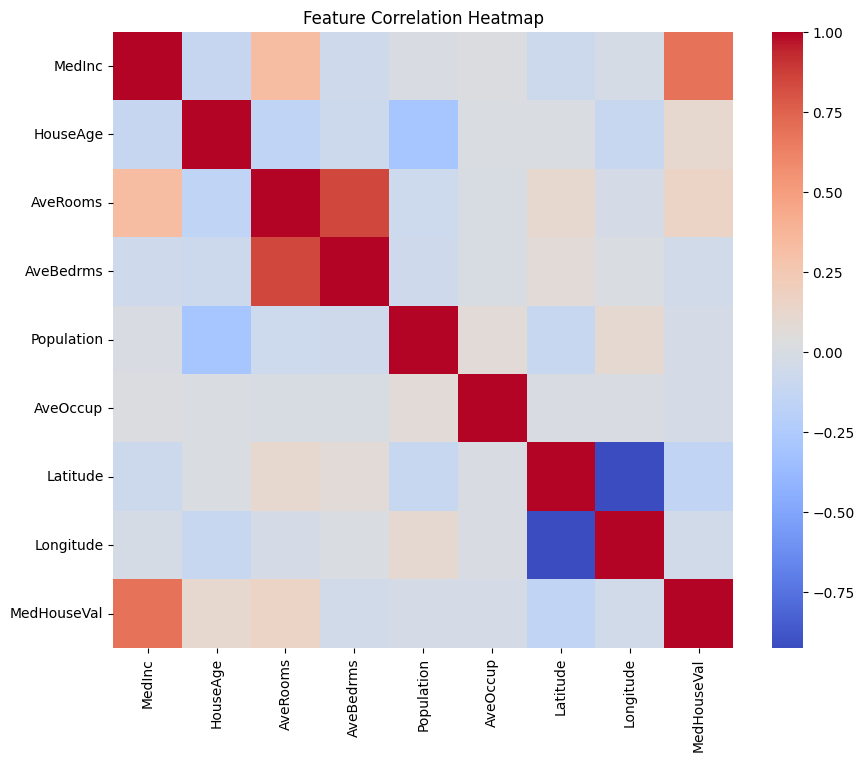

In [9]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), cmap='coolwarm', annot=False)
plt.title('Feature Correlation Heatmap')
plt.show()

## Conclusion
- Scaling ensures stable training and balanced feature influence.
- Polynomial and log transformations reveal non-linear patterns.
- Feature selection simplifies models while maintaining accuracy.

**Feature engineering bridges raw data and intelligent modeling — a crucial step in building high-performing ML systems.**